<a href="https://colab.research.google.com/github/art-glazunov/Non-standard-categorical-encodings/blob/main/group_counts_and_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-standard categorical encodings
by Artyom Glazunov
#Part 2.1. Group counts + Truncated SVD

### In this notebook, you can check out how group counts and truncated SVD can help with categorical encoding and getting object embeddings in an unsupervised manner. Such embeddings can be useful for solving many supervised and unsupervised learning tasks.
Inspired by https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Group2Vec/Group2Vec.ipynb


In [ ]:
import pandas as pd
import numpy as np

import itertools
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from typing import List, NewType
MixingCategoricalEmbedderObject = NewType('MixingCategoricalEmbedderObject', object) #creating new type to annotate in our class

Download our train dataset from https://www.kaggle.com/c/cat-in-the-dat/data?select=train.csv into your directory, here I use a folder on my Google Drive to store the data. Of course, you can simply load the data into the folder on the left, without Google Drive. But if you want to mount your drive, you can do as instructed here https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166, *or just use a button on the left panel*). 

Change working dir

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/article

/content/drive/MyDrive/Colab_Notebooks/article


Check the folder

In [ ]:
!ls

group_counts_and_entropy.ipynb	group_counts_and_SVD.ipynb  train.csv


Our file is here, let's load the data and split it into train and test parts

In [ ]:
data = pd.read_csv('train.csv', index_col = 'id')
train = data.iloc[:-70000]
print(train.shape)
train.head()

(230000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [ ]:
test = data.iloc[-70000:]
print(test.shape)
test.head()

(70000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
230000,1,1,0,F,Y,Green,Square,Dog,Russia,Piano,92190168b,fa498a5ae,d10553e7e,80be47228,47d38e9d3,1,Master,Lava Hot,e,U,MO,4,2,0
230001,0,0,0,T,Y,Red,Star,Lion,Canada,Piano,e7d9ca356,0b23e3352,40f84f6de,333f46907,e9e56a3f8,1,Expert,Boiling Hot,i,O,CM,1,1,0
230002,0,0,0,F,Y,Red,Circle,Cat,Canada,Bassoon,a3f640358,9b1c3c8b7,d1586e0e0,1b9339c49,973983691,3,Grandmaster,Freezing,b,T,RL,3,8,1
230003,1,0,0,T,N,Green,Trapezoid,Hamster,Costa Rica,Bassoon,0b3bec656,603232dea,5387ed7d2,da8be1022,508c9de37,1,Novice,Warm,e,U,Qo,2,11,0
230004,1,0,0,T,Y,Blue,Star,Axolotl,Canada,Piano,4173a0252,c135cdf77,91cd074b1,1a2fd4686,75193d88a,3,Novice,Hot,g,U,LE,4,12,1


Select only features

In [ ]:
categorical_cols = [col for col in train.columns if col != 'target']
print(categorical_cols)
len(categorical_cols)

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


23

So, get the data in a convenient format

In [ ]:
X_train = train[categorical_cols]
y_train = train['target']
X_test = test[categorical_cols]
y_test = test['target']

### Create a custom class for our embedder

In [ ]:
class MixingCategoricalEmbedder:
    """Unsupervised categorical embedder based on group counts and TruncatedSVD

    fit - get dictionary for the transformation of categorical objects into embeddings 
    transform - map the dictionary onto your categorical dataset to get the embeddings
    """

    def __init__(self, n_components: int = 5, 
                n_svd_iter: int = 10,
                random_state: int = 33):
        self.n_components = n_components #n components for the pair group_key-passive_key
        self.n_iter = n_svd_iter
        self.random_state = random_state
        self.substitute_dict = {} #resulting dictionary to transform the objects into embs

    def __repr__(self):
        return self.__class__.__name__ + f"(n_components = {self.n_components}, " +\
                                        f"n_svd_iter = {self.n_iter}, "  +\
                                        f"random_state = {self.random_state})"
    
    @staticmethod
    def cat_prep(data: pd.DataFrame) -> pd.DataFrame:
        """change category names for simplification

        format -> category-name_category-name
        """

        data_new = data.copy()
        for col in tqdm(data.columns):
          data_new[col] = data[col].apply(lambda x: col + '_' + str(x))
        return data_new
    
    def fit(self, df_train: pd.DataFrame, verbose: bool = True) -> MixingCategoricalEmbedderObject: # we created this custom type earlier
        """Create dictionary to map on the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (cat_prep) 
        (each row is our object to get an embedding for)
        """

        df_train = df_train.copy()
        feature_list = list(df_train.columns)
        for group_key in tqdm(feature_list):    
            passive_keys = feature_list[:]
            passive_keys.remove(group_key)

            category_embedding_mapping = {}
            for passive_key in passive_keys:
                if verbose:
                    print('--- groupby: group_key - ', group_key, '### passive_key - ', passive_key, '---')
                groups = df_train[[group_key, passive_key]].groupby(group_key)[passive_key]
                groups = groups.apply(lambda x: ' '.join(list(x))) #for each group key category get a string
                group_key_categories = groups.index
                enc_count = CountVectorizer()
                groups_counts = enc_count.fit_transform(groups) #get matrix
                if len(enc_count.vocabulary_) <= self.n_components: #for low cardinality features and small vocabs
                  LSA = TruncatedSVD(n_components = len(enc_count.vocabulary_) - 1, 
                                    random_state=self.random_state, 
                                    n_iter=self.n_iter)
                else:
                  LSA = TruncatedSVD(n_components=self.n_components, #ordinary case
                                    random_state=self.random_state, 
                                    n_iter=self.n_iter)
                category_embeddings = LSA.fit_transform(groups_counts) #truncation
                
                for i, category in enumerate(group_key_categories):
                    if category in category_embedding_mapping:
                        category_embedding_mapping[category].extend(list(category_embeddings[i]))
                    else:
                        category_embedding_mapping[category] = list(category_embeddings[i])
            
            self.substitute_dict[group_key] = category_embedding_mapping    
        return self

    def transform(self, dataset: pd.DataFrame, 
                  fill_unknown_cat_value: int = 0,
                  verbose: bool = False) -> List[list]:
        """Get embedding for each categorical row of the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (cat_prep) 
        (each row is our object to get an embedding for)
        fill_unknown_cat_value - the value to fill embedding vector for unknown categories
        """

        dataset = dataset.copy()
        feature_list = list(dataset.columns)
        if verbose:
          print("Mapping vectors to categories...")
        for f in tqdm(feature_list):
            dataset[f] = dataset[f].map(self.substitute_dict[f])               
            dataset[f] = dataset[f].fillna('empty')
            emb_size = len(self.substitute_dict[f][list(self.substitute_dict[f].keys())[0]])
            dataset[f] = dataset[f].apply(lambda x: [fill_unknown_cat_value] * emb_size if x == 'empty' else x)

        embeddings_list = []
        if verbose:
          print("Creating an embedding for each row...")
        for row in tqdm(dataset[feature_list].itertuples()):
            embeddings_list.append(list(itertools.chain(*row[1:])))

        return embeddings_list


Let's use our preprocessing method to prepare the dataset for the embedder

In [ ]:
df_train = X_train.copy()
df_train = MixingCategoricalEmbedder.cat_prep(df_train)
df_train.head()

  0%|          | 0/23 [00:00<?, ?it/s]

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
0,bin_0_0,bin_1_0,bin_2_0,bin_3_T,bin_4_Y,nom_0_Green,nom_1_Triangle,nom_2_Snake,nom_3_Finland,nom_4_Bassoon,nom_5_50f116bcf,nom_6_3ac1b8814,nom_7_68f6ad3e9,nom_8_c389000ab,nom_9_2f4cb3d51,ord_0_2,ord_1_Grandmaster,ord_2_Cold,ord_3_h,ord_4_D,ord_5_kr,day_2,month_2
1,bin_0_0,bin_1_1,bin_2_0,bin_3_T,bin_4_Y,nom_0_Green,nom_1_Trapezoid,nom_2_Hamster,nom_3_Russia,nom_4_Piano,nom_5_b3b4d25d0,nom_6_fbcb50fc1,nom_7_3b6dd5612,nom_8_4cd920251,nom_9_f83c56c21,ord_0_1,ord_1_Grandmaster,ord_2_Hot,ord_3_a,ord_4_A,ord_5_bF,day_7,month_8
2,bin_0_0,bin_1_0,bin_2_0,bin_3_F,bin_4_Y,nom_0_Blue,nom_1_Trapezoid,nom_2_Lion,nom_3_Russia,nom_4_Theremin,nom_5_3263bdce5,nom_6_0922e3cb8,nom_7_a6a36f527,nom_8_de9c9f684,nom_9_ae6800dd0,ord_0_1,ord_1_Expert,ord_2_Lava Hot,ord_3_h,ord_4_R,ord_5_Jc,day_7,month_2
3,bin_0_0,bin_1_1,bin_2_0,bin_3_F,bin_4_Y,nom_0_Red,nom_1_Trapezoid,nom_2_Snake,nom_3_Canada,nom_4_Oboe,nom_5_f12246592,nom_6_50d7ad46a,nom_7_ec69236eb,nom_8_4ade6ab69,nom_9_8270f0d71,ord_0_1,ord_1_Grandmaster,ord_2_Boiling Hot,ord_3_i,ord_4_D,ord_5_kW,day_2,month_1
4,bin_0_0,bin_1_0,bin_2_0,bin_3_F,bin_4_N,nom_0_Red,nom_1_Trapezoid,nom_2_Lion,nom_3_Canada,nom_4_Oboe,nom_5_5b0f5acd5,nom_6_1fe17a1fd,nom_7_04ddac2be,nom_8_cb43ab175,nom_9_b164b72a7,ord_0_1,ord_1_Grandmaster,ord_2_Freezing,ord_3_a,ord_4_R,ord_5_qP,day_7,month_8


In [ ]:
df_test = X_test.copy()
df_test = MixingCategoricalEmbedder.cat_prep(df_test)
df_test.head()

  0%|          | 0/23 [00:00<?, ?it/s]

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
230000,bin_0_1,bin_1_1,bin_2_0,bin_3_F,bin_4_Y,nom_0_Green,nom_1_Square,nom_2_Dog,nom_3_Russia,nom_4_Piano,nom_5_92190168b,nom_6_fa498a5ae,nom_7_d10553e7e,nom_8_80be47228,nom_9_47d38e9d3,ord_0_1,ord_1_Master,ord_2_Lava Hot,ord_3_e,ord_4_U,ord_5_MO,day_4,month_2
230001,bin_0_0,bin_1_0,bin_2_0,bin_3_T,bin_4_Y,nom_0_Red,nom_1_Star,nom_2_Lion,nom_3_Canada,nom_4_Piano,nom_5_e7d9ca356,nom_6_0b23e3352,nom_7_40f84f6de,nom_8_333f46907,nom_9_e9e56a3f8,ord_0_1,ord_1_Expert,ord_2_Boiling Hot,ord_3_i,ord_4_O,ord_5_CM,day_1,month_1
230002,bin_0_0,bin_1_0,bin_2_0,bin_3_F,bin_4_Y,nom_0_Red,nom_1_Circle,nom_2_Cat,nom_3_Canada,nom_4_Bassoon,nom_5_a3f640358,nom_6_9b1c3c8b7,nom_7_d1586e0e0,nom_8_1b9339c49,nom_9_973983691,ord_0_3,ord_1_Grandmaster,ord_2_Freezing,ord_3_b,ord_4_T,ord_5_RL,day_3,month_8
230003,bin_0_1,bin_1_0,bin_2_0,bin_3_T,bin_4_N,nom_0_Green,nom_1_Trapezoid,nom_2_Hamster,nom_3_Costa Rica,nom_4_Bassoon,nom_5_0b3bec656,nom_6_603232dea,nom_7_5387ed7d2,nom_8_da8be1022,nom_9_508c9de37,ord_0_1,ord_1_Novice,ord_2_Warm,ord_3_e,ord_4_U,ord_5_Qo,day_2,month_11
230004,bin_0_1,bin_1_0,bin_2_0,bin_3_T,bin_4_Y,nom_0_Blue,nom_1_Star,nom_2_Axolotl,nom_3_Canada,nom_4_Piano,nom_5_4173a0252,nom_6_c135cdf77,nom_7_91cd074b1,nom_8_1a2fd4686,nom_9_75193d88a,ord_0_3,ord_1_Novice,ord_2_Hot,ord_3_g,ord_4_U,ord_5_LE,day_4,month_12


Initialize an embedder

In [ ]:
embedder = MixingCategoricalEmbedder()
embedder

MixingCategoricalEmbedder(n_components = 5, n_svd_iter = 10, random_state = 33)

Let's train it and get results

In [ ]:
embedder.fit(df_train, verbose=False)

  0%|          | 0/23 [00:00<?, ?it/s]

MixingCategoricalEmbedder(n_components = 5, n_svd_iter = 10, random_state = 33)

In [ ]:
%%time
train_feat = embedder.transform(df_train)

  0%|          | 0/23 [00:00<?, ?it/s]

0it [00:00, ?it/s]

CPU times: user 26.7 s, sys: 3.42 s, total: 30.1 s
Wall time: 29.8 s


In [ ]:
%%time
test_feat = embedder.transform(df_test)

  0%|          | 0/23 [00:00<?, ?it/s]

0it [00:00, ?it/s]

CPU times: user 6.88 s, sys: 798 ms, total: 7.67 s
Wall time: 7.63 s


Let's look at our embeddings

In [ ]:
np.array(test_feat)

array([[ 2.32931749e+04,  2.14247962e+04,  2.08765171e+04, ...,
         7.18948292e+01, -7.15049291e+01,  4.99281724e+01],
       [ 1.57633066e+05,  1.45627870e+05,  1.41802857e+05, ...,
        -5.48186116e+01, -4.46609466e+00,  1.44024179e+01],
       [ 1.57633066e+05,  1.45627870e+05,  1.41802857e+05, ...,
        -7.80796864e+01, -3.68163541e+01,  7.70808345e+00],
       ...,
       [ 1.57633066e+05,  1.45627870e+05,  1.41802857e+05, ...,
         1.71691077e+01,  8.33400489e+01,  9.02535782e+01],
       [ 1.57633066e+05,  1.45627870e+05,  1.41802857e+05, ...,
        -7.80796864e+01, -3.68163541e+01,  7.70808345e+00],
       [ 1.57633066e+05,  1.45627870e+05,  1.41802857e+05, ...,
        -1.34530036e+01, -6.47085424e+01, -3.07012781e+01]])

You can see that we have some problems with scale of the components


In [ ]:
np.array(test_feat).shape

(70000, 1595)

Estimate of OHE dimensionality

In [ ]:
number_of_cat = 0
for col in df_train.columns:
  number_of_cat += df_train[col].unique().shape[0]
number_of_cat

16380

You can see that the dimensionality of the embedding is an order of magnitude less than in the case of OHE

### Here we'll test it via our classification task. How much information we've preserved?

LightGBM.


In [ ]:
%%time
lgmb_clf = lgb.LGBMClassifier(random_state=33).fit(train_feat, y_train)

CPU times: user 10min 19s, sys: 15.6 s, total: 10min 35s
Wall time: 3min 33s


In [ ]:
probs = lgmb_clf.predict_proba(test_feat)
score_lgbm = roc_auc_score(y_test, probs[:,1])
print(score_lgbm)

0.7698978517465562


Let's look at feature importances

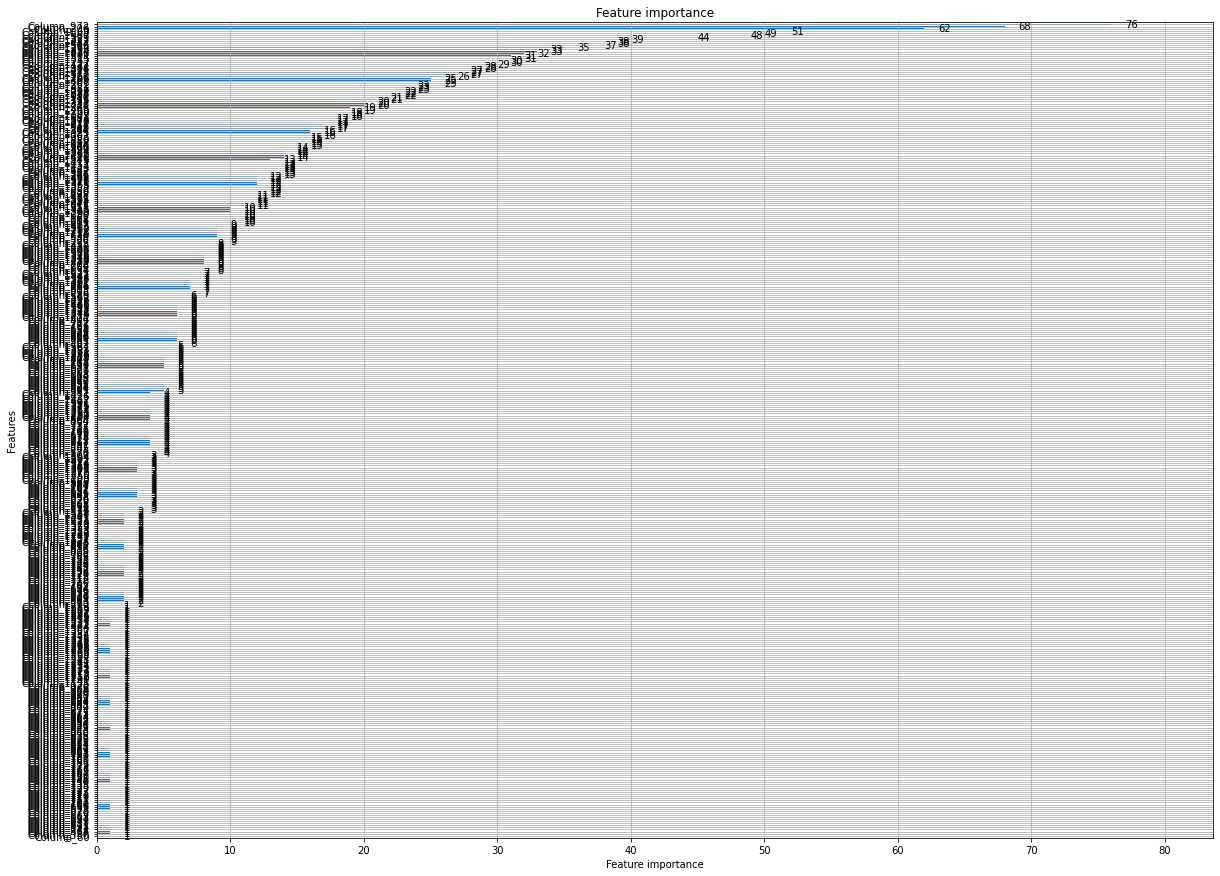

In [ ]:
lgb.plot_importance(lgmb_clf, importance_type='split', figsize=(20,15));

You can see that in this case we have a less imbalanced distribution of the feature importances than in the case of using topic modeling (LSA), but the problem still exists.

Logistic Regression

In [ ]:
lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('classifier', LogisticRegression())])
lr_pipe.fit(train_feat, y_train)
probs = lr_pipe.predict_proba(test_feat)
score_lr_scaled = roc_auc_score(y_test, probs[:,1])
print(score_lr_scaled)

0.7585998965255265


Conclusions:

Pros:
- Fast
- Many options for tuning
- Flexibility,  we can choose dimensionality!
- High quality embeddings
- Good fit for medium-sized data with many high cardinality variables

Cons:
-	What to do if we have lots of low cardinality variables?
-	Scaling?
-	Correlation?


# Visualization

Generate a subsample to visualize.

In [ ]:
_, emb_sample, _, _ = train_test_split(test_feat, y_test, test_size=0.03, random_state=85)

Scale the data


In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(train_feat)

scaled_emb = scaler.transform(emb_sample)

CPU times: user 45.9 s, sys: 442 ms, total: 46.4 s
Wall time: 45.8 s


t-SNE

In [ ]:
%%time
tsne = TSNE(n_components=2, random_state=33)
T = tsne.fit_transform(scaled_emb)

CPU times: user 1min 6s, sys: 197 ms, total: 1min 7s
Wall time: 33.4 s


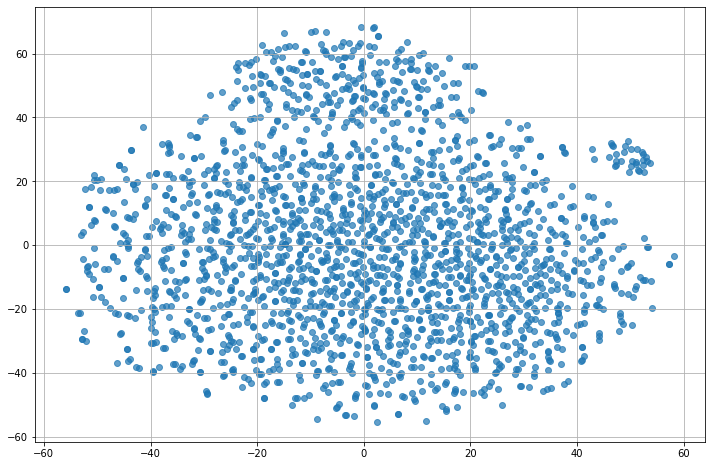

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(T[:, 0], T[:, 1], alpha=0.7)
plt.grid()

### We can see some clusters here! Not bad:)

MDS

In [ ]:
%%time
mds_trans = MDS(n_components=2, random_state=33)
M = mds_trans.fit_transform(scaled_emb)

CPU times: user 4min 4s, sys: 6min 35s, total: 10min 40s
Wall time: 2min 54s


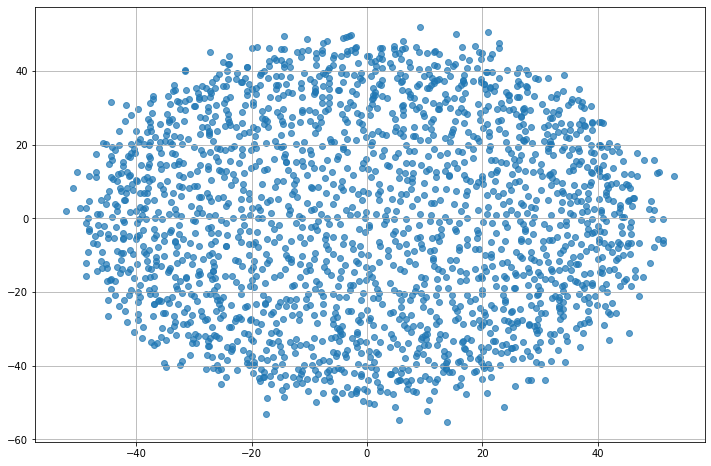

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(M[:,0], M[:,1], alpha=0.7)
plt.grid()

### There are no clusters on the MDS picture, but maybe next time we will be able to notice some after testing our last embedder. Stay tuned :) 